In [9]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import json
import joblib as joblib

import re
import string
import dill

In [10]:
# nltk.download('punkt')
# pip install unidecode
from unidecode import unidecode

In [11]:
# Load data
data_train = pd.read_csv('../../Data Splits/train_data_70_30.csv')
data_test = pd.read_csv('../../Data Splits/test_data_70_30.csv')

In [12]:
X_train = data_train['article']
y_train = data_train['label']

X_test = data_test['article']
y_test = data_test['label']

In [13]:
# Stopword Removal
ps = PorterStemmer()
with open('../../Datasets/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

# Custom transformer for text preprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join(self.preprocess(text)) for text in X]
    
    def preprocess(self, text):
        # Lowercase Conversion
        lowered = text.lower()

        # URL Removal
        urled = re.sub(r'https?://\S+|www\.\S+', '', lowered)
        
        # Text Simplification
        text = re.sub(r'\[.*?\]', '', urled)
        text = re.sub(r"\\W", " ", text)
        text = re.sub(r'<.*?>+', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\w*\d\w*', '', text)

        # Tokenization
        tokens = nltk.word_tokenize(text)
        stems = [ps.stem(token) for token in tokens]
        filtered = [stem for stem in stems if stem not in stopwords]
        return filtered

In [14]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

In [15]:
# Define the XGBClassifier as meta learner
mlp = MLPClassifier()

# Define the parameter grid
param_grid = {
            'hidden_layer_sizes': [(10,), (20,), (50,), (100,)], 
            'activation': ['relu', 'tanh', 'logistic'], 
            'solver': ['sgd', 'adam'], 
            'learning_rate': ['constant', 'adaptive']
            }

In [16]:
# Define the steps in your pipeline
steps = [
    ('preprocess', TextPreprocessor()),
    ('vectorizer',  TfidfVectorizer()),
    ('gridsearch', GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1))

]

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('vectorizer', TfidfVectorizer()),
                ('gridsearch',
                 GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
                              param_grid={'activation': ['relu', 'tanh',
                                                         'logistic'],
                                          'hidden_layer_sizes': [(10,), (20,),
                                                                 (50,),
                                                                 (100,)],
                                          'learning_rate': ['constant',
                                                            'adaptive'],
                                          'solver': ['sgd', 'adam']},
                              scoring='accuracy'))])

In [18]:
best_meta = pipeline.named_steps['gridsearch'].best_estimator_
joblib.dump(pipeline.named_steps['gridsearch'] , '../../Models/pipeline_mlp_gridsearch.joblib')

['../../Models/pipeline_mlp_gridsearch.joblib']

In [19]:
print("Best Hyperparameters: ", pipeline.named_steps['gridsearch'].best_params_)
print("Best Accuracy: {:.2f}%".format(pipeline.named_steps['gridsearch'].best_score_ * 100))

Best Hyperparameters:  {'activation': 'logistic', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
Best Accuracy: 94.25%


In [20]:
steps = [
    ('preprocess', TextPreprocessor()),
    ('vectorizer',  TfidfVectorizer()),
    ('stacking', StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta ,cv=5))
    ]
stack = Pipeline(steps)
stack.fit(X_train, y_train)

c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('vectorizer', TfidfVectorizer()),
                ('stacking',
                 StackingClassifier(cv=5,
                                    estimators=[('MNB', MultinomialNB()),
                                                ('LR', LogisticRegression()),
                                                ('RF',
                                                 RandomForestClassifier()),
                                                ('KNN', KNeighborsClassifier()),
                                                ('SVM', SVC(probability=True))],
                                    final_estimator=MLPClassifier(activation='logistic',
                                                                  hidden_layer_sizes=(50,))))])

Metrics for MNB:
Accuracy: 0.8059866962305987
Precision: 0.7249190938511327
Recall: 0.9889624724061811
F1 Score: 0.8366013071895425
AUC: 0.9726151319832643
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.62      0.76       449
           1       0.72      0.99      0.84       453

    accuracy                           0.81       902
   macro avg       0.85      0.81      0.80       902
weighted avg       0.85      0.81      0.80       902



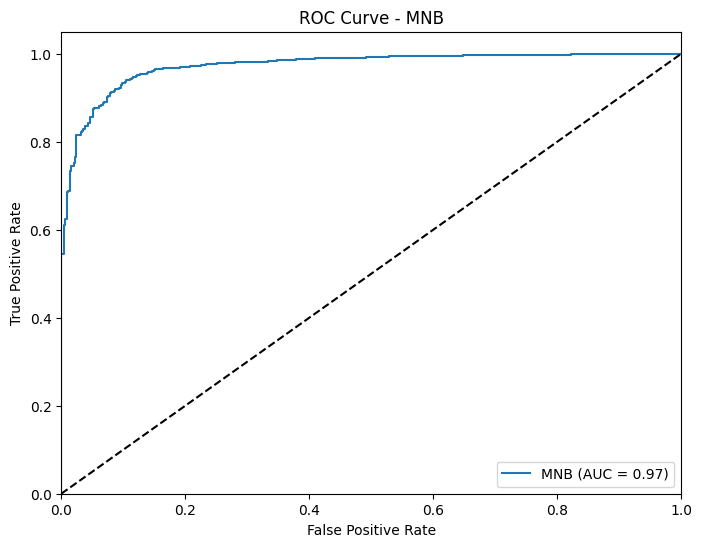

Metrics for LR:
Accuracy: 0.9068736141906873
Precision: 0.944578313253012
Recall: 0.8653421633554084
F1 Score: 0.9032258064516129
AUC: 0.9750930446368432
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       449
           1       0.94      0.87      0.90       453

    accuracy                           0.91       902
   macro avg       0.91      0.91      0.91       902
weighted avg       0.91      0.91      0.91       902



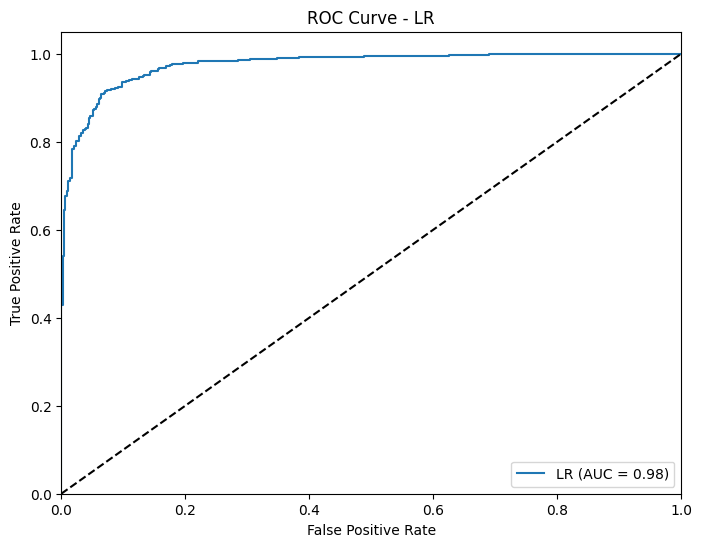

Metrics for RF:
Accuracy: 0.9146341463414634
Precision: 0.9541062801932367
Recall: 0.8719646799116998
F1 Score: 0.9111880046136102
AUC: 0.97146958903032
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       449
           1       0.95      0.87      0.91       453

    accuracy                           0.91       902
   macro avg       0.92      0.91      0.91       902
weighted avg       0.92      0.91      0.91       902



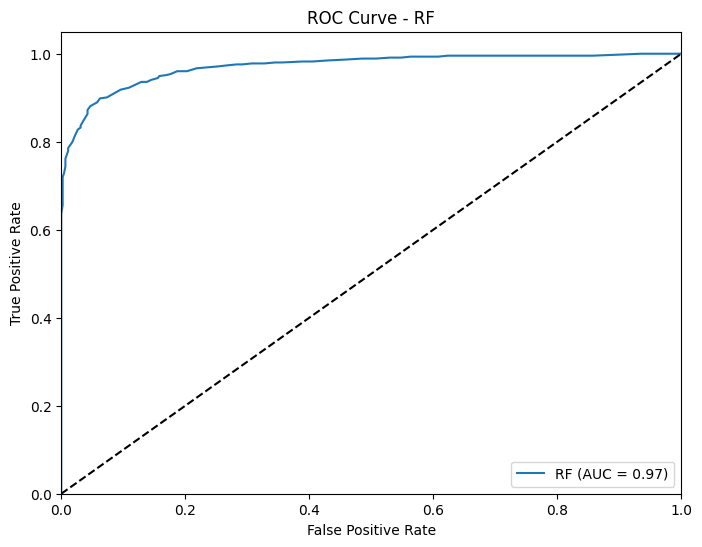

Metrics for KNN:
Accuracy: 0.844789356984479
Precision: 0.7861060329067642
Recall: 0.9492273730684326
F1 Score: 0.86
AUC: 0.9381160980742095
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.74      0.83       449
           1       0.79      0.95      0.86       453

    accuracy                           0.84       902
   macro avg       0.86      0.84      0.84       902
weighted avg       0.86      0.84      0.84       902



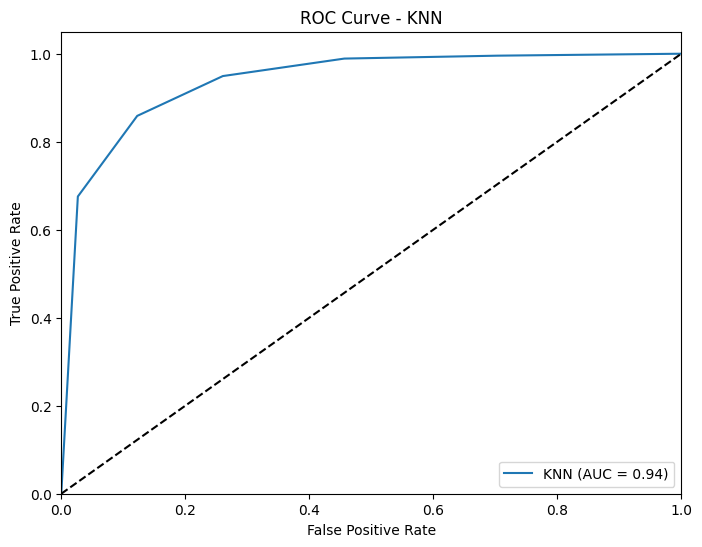

Metrics for SVM:
Accuracy: 0.9135254988913526
Precision: 0.9652605459057072
Recall: 0.8587196467991169
F1 Score: 0.9088785046728972
AUC: 0.9817376854132559
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       449
           1       0.97      0.86      0.91       453

    accuracy                           0.91       902
   macro avg       0.92      0.91      0.91       902
weighted avg       0.92      0.91      0.91       902



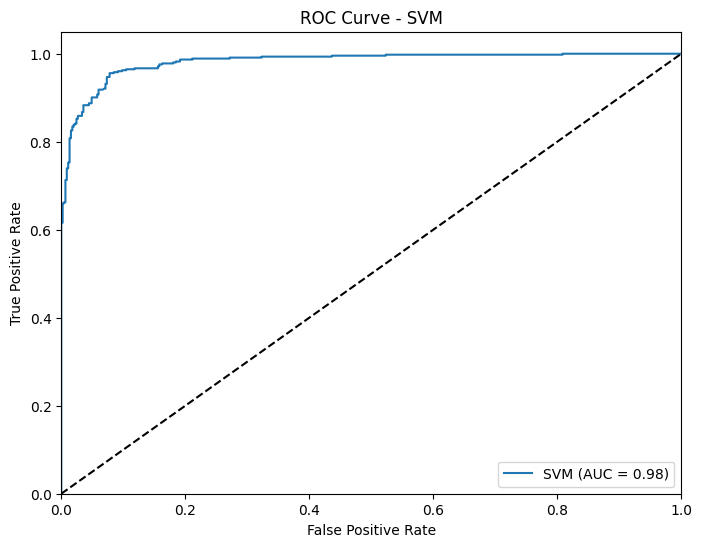

In [21]:


# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Use TFIDF inside of stacking to vectorize X_test(Evaluation)
vectorized_text = stack.named_steps['vectorizer'].transform(X_test)

# Evaluate base models
for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 0.9512195121951219
Precision: 0.9455337690631809
Recall: 0.9580573951434879
F1 Score: 0.9517543859649122
AUC: 0.9913912201261571
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       449
           1       0.95      0.96      0.95       453

    accuracy                           0.95       902
   macro avg       0.95      0.95      0.95       902
weighted avg       0.95      0.95      0.95       902



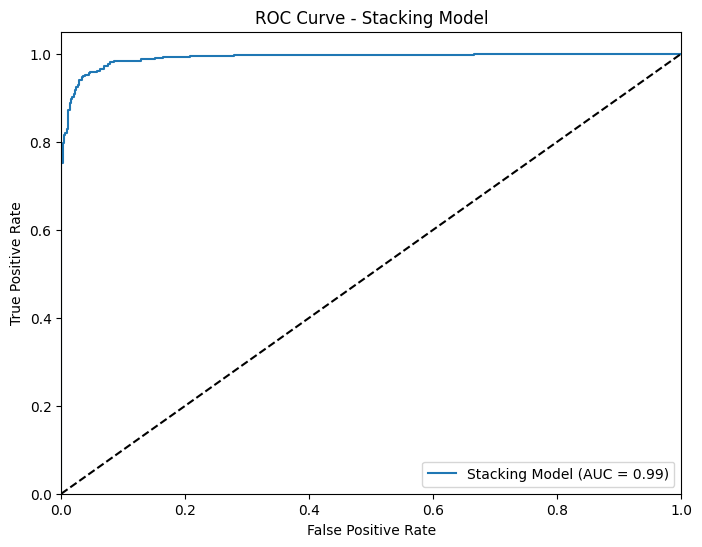

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.805987  0.724919  0.988962  0.836601  0.972615
LR              0.906874  0.944578  0.865342  0.903226  0.975093
RF              0.914634  0.954106  0.871965  0.911188   0.97147
KNN             0.844789  0.786106  0.949227      0.86  0.938116
SVM             0.913525  0.965261   0.85872  0.908879  0.981738
Stacking Model   0.95122  0.945534  0.958057  0.951754  0.991391


In [22]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_test)
stack_y_prob = stack.predict_proba(X_test)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_test, stack_y_pred)
stack_precision = precision_score(y_test, stack_y_pred)
stack_recall = recall_score(y_test, stack_y_pred)
stack_f1 = f1_score(y_test, stack_y_pred)
stack_auc = roc_auc_score(y_test, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_test, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_test, stack_y_prob)
stack_roc_auc = roc_auc_score(y_test, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

In [23]:
# Save the model using joblib
joblib.dump(stack, '../../Models/pipeline_mlp.joblib')



['../../Models/pipeline_mlp.joblib']